# Supervised learning
We aim to create a supervised machine learning model using linear regression that can suggest a reasonable price for new landlords listing a property on Airbnb. The goal is to assist them in understanding market pricing based on relevant property features.

In [2]:
import pandas as pd

df = pd.read_csv('../data/supervised_cleaned_airbnb_data.csv')

df.head()

,ID,realSum,room_type,room_shared_bool,room_private_bool,person_capacity,host_is_superhost_bool,multi_bool,biz_bool,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,City,Is_weekend_bool
0,0,194.03,1,0,1,2,0,1,0,10,93,1,5.0,2.5,1,0
1,1,344.25,1,0,1,4,0,0,0,8,85,1,0.5,0.2,1,0
2,2,264.10,1,0,1,2,0,0,1,9,87,1,5.7,3.7,1,0
3,3,433.53,1,0,1,4,0,0,1,9,90,2,0.4,0.4,1,0
4,4,485.55,1,0,1,2,1,0,0,10,98,1,0.5,0.3,1,0


All data has been converted into numerical format so it can be used by the regression model.
Categorical values like room type or city were encoded to support this process.

| Column name                  | Description                                                       |
|-----------------------------|-------------------------------------------------------------------|
| **realSum**                 | The total price of the Airbnb listing. **(Numeric)**                 |
| **room_type**               | 1. Private room, 2. Entire home/apt, 3. Shared room **(Numeric)** |
| **room_shared_bool**             | Whether the room is shared or not. **(Boolean)**                     |
| **room_private_bool**            | Whether the room is private or not. **(Boolean)**                    |
| **person_capacity**         | The maximum number of people that can stay in the room. **(Numeric)** |
| **host_is_superhost_bool**       | Whether the host is a superhost or not. **(Boolean)**                |
| **multi_bool**                   | Whether the listing is for multiple rooms or not. **(Boolean)**      |
| **biz_bool**                     | Whether the listing is for business purposes or not. **(Boolean)**   |
| **cleanliness_rating**      | The cleanliness rating of the listing. **(Numeric)**                 |
| **guest_satisfaction_overall** | The overall guest satisfaction rating of the listing. **(Numeric)** |
| **bedrooms**                | The number of bedrooms in the listing. **(Numeric)**                 |
| **dist**                    | The distance from the city centre. **(Numeric)**                     |
| **metro_dist**              | The distance from the nearest metro station. **(Numeric)**           |
| **City**                    | 1. Amsterdam, 2. Athen, 3. Barcelona, 4. Berlin, 5. Budapest, 6. Lisbon, 7. London, 8. Paris, 9. Rome, 10. Vienna **(Numeric)** |
| **Is_weekend_bool**         | Whether the home is available on weekends or not. **(Boolean)**      |

## Model 1
Initially we thought it would be a good idea, to have a single model that took data from all cities across Europe. This model proved to be quite far off the mark.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# The ratings are omitted as a new home would not have ratings upfront.
# We also did not care about multiple rooms or business purpose.

# x = The features/columns we want our model to look at when making the model
X = df[['room_type','room_shared_bool','room_private_bool','person_capacity','bedrooms','dist','metro_dist', 'City','Is_weekend_bool']]  
# y = The price we wish to compare with
y = df['realSum'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [7]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

def predict_price(room_type, room_shared_bool, room_private_bool, person_capacity, bedrooms, dist, metro_dist, City, Is_weekend_bool):
    input_data = [[room_type, room_shared_bool, room_private_bool, person_capacity, bedrooms, dist, metro_dist, City, Is_weekend_bool]]
    predicted_price = model.predict(input_data)[0]
    return round(predicted_price, 2)

amsterdam = predict_price(
    room_type=1,
    room_shared_bool=0,
    room_private_bool=1,
    person_capacity=2,
    bedrooms=1,
    dist=5.0,
    metro_dist=2.5,
    City=2,        
    Is_weekend_bool=0
)


london = predict_price(
    room_type=1,
    room_shared_bool=0,
    room_private_bool=1,
    person_capacity=2,
    bedrooms=1,
    dist=5.0,
    metro_dist=2.5,
    City=7,        
    Is_weekend_bool=0
)

athens = predict_price(
    room_type=1,
    room_shared_bool=0,
    room_private_bool=1,
    person_capacity=2,
    bedrooms=1,
    dist=5.0,
    metro_dist=2.5,
    City=2,        
    Is_weekend_bool=0
)

print("Predicted price Amsterdam:", amsterdam)
print("Predicted price London:", london)
print("Predicted price Athens:", athens)

Predicted price Amsterdam: 152.28
Predicted price London: 153.23
Predicted price Athens: 152.28


First we wanted to test the predicted price against an actual price in the dataset. The values used to predict a price comes from the first entry in the dataset. The actual price of the first entry in the dataset is $194.03 leaving us 42.15 off the mark (Amsterdam)

Another expected result would be the price being different from city to city. London is a very expensive city but the price is nearly identical regardless of the chosen city. 

This led us to do some more testing and we decided on another approach to the model. Instead of having a single model we would have 1 model for each city and compare the results to our first model.

## Model 2
1 model per city

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

city_models = {}


for city, city_data in df.groupby('City'):
    X = city_data[['room_type','room_shared_bool','room_private_bool','person_capacity','bedrooms','dist','metro_dist','Is_weekend_bool']]
    y = city_data['realSum']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    # Store the trained model
    city_models[city] = model



In [11]:
# Example features: room_type, room_shared_bool, room_private_bool, person_capacity, bedrooms, dist, metro_dist, Is_weekend_bool

# Same values as the first test

# amsterdam, athens and london contains the same values except for the city (the first entry in the data set)
amsterdam = {
    "data": [[1, 0, 1, 2, 1, 5.0, 2.5, 0]],
    "cityId": 1
}
athens = {
    "data": [[1, 0, 1, 2, 1, 5.0, 2.5, 0]],
    "cityId": 2
}

london = { 
    "data": [[1, 0, 1, 2, 1, 5.0, 2.5, 0]],
    "cityId": 7
}

# No listings in Athens had a distance from center or metro at 5,0 and 2,5 km. We changed these values to reflect actual values present in the dataset.
athens2 = {
    "data": [[1, 0, 1, 2, 1, 1.0, 0.5, 0]],
    "cityId": 2
}

cities = {
"1": "Amsterdam",
"2" : "Athen",
"3": "Barcelona",
"4": "Berlin",
"5": "Budapest",
"6": "Lisbon",
"7": "London",
"8": "Paris",
"9": "Rome",
"10": "Vienna"
}

def predict_price(dataObject):
    city_id = dataObject["cityId"]
    model = city_models.get(city_id)
    if model:
        predicted_price = model.predict(dataObject["data"])[0]
        print(f"\033[1mPredicted price for {cities[str(city_id)]}: ${round(predicted_price, 2)}\033[0m")
    else:
        print(f"No model found for city {city_id}")

predict_price(amsterdam)
predict_price(athens)
predict_price(athens2)
predict_price(london)

Predicted price for Amsterdam: $212.99
Predicted price for Athen: $-62.11
Predicted price for Athen: $136.31
Predicted price for London: $228.73


With our new model we test the same values as model 1 used.

Now the prices are more varied and going to Athens seems like a great deal to us! We investigated the dataset and the reason for the minus value in Athens.
It turns out that all homes in Athens are very close to the city center and the metro. Changing the value of these 2 parameters provides a more fitting price (athens2 contains changed values).


While the Amsterdam price predicted does not match the original $194.03 from the first entry. It is still closer than the first model. There could be various parameters that are unknown to us. The condition of the interior can for instance vary a lot. Maybe theres an old bathroom and the furniture is not of great quality. A landlord might also want to compete on price putting the home lower than what could have been the case.




## Try the model
With our models for each city ready, we need to have a way to interact with the model. In the following code the user can enter data about his home and receive a predicted price based on our 2nd model.

In [25]:
# Helper functions to ensure proper input validation
def get_integer(prompt, min_val=None, max_val=None):
    while True:
        try:
            value = int(input(prompt))
            if (min_val is not None and value < min_val) or (max_val is not None and value > max_val):
                print(f"Please enter a number between {min_val} and {max_val}.")
            else:
                return value
        except ValueError:
            print("Invalid input. Please enter a whole number.")

def get_float(prompt, min_val=0.1):
    while True:
        try:
            value = float(input(prompt))
            if (min_val is not None and value < min_val):
                print(f"Please enter a number higher than or equal to {min_val}.")
            else:
                return value
        except ValueError:
            print("Invalid input. Please enter a decimal number (e.g., 3.5).")

def get_boolean(prompt):
    while True:
        try:
            value = int(input(prompt))
            if value in (0, 1):
                return value
            else:
                print("Please enter 0 (False) or 1 (True).")
        except ValueError:
            print("Invalid input. Please enter 0 or 1.")

# Input dictionary 
input_data = {
    "data": [[]],
    "cityId": 0
}

# Receive input data from the user with validation
cityId = get_integer(
    "Select city: 1. Amsterdam, 2. Athens, 3. Barcelona, 4. Berlin, 5. Budapest, 6. Lisbon, 7. London, 8. Paris, 9. Rome, 10. Vienna: ",
    min_val=1, max_val=10
)
room_type = get_integer("Room type (1. Private room, 2. Entire home/apt, 3. Shared room): ", min_val=1, max_val=3)
room_shared_bool = get_boolean("Shared room? (0 = false, 1 = true): ")
room_private_bool = get_boolean("Private room? (0 = false, 1 = true): ")
person_capacity = get_integer("How many people is this home capable of hosting? ", min_val=1)
bedrooms = get_integer("How many bedrooms? ", min_val=0)
dist = get_float("How far from the city centre? (e.g., 3.5): ")
metro_dist = get_float("How far from the metro? (e.g., 1.5): ")
Is_weekend_bool = get_boolean("Is it a weekend? (0 = false, 1 = true): ")

# Combine input data into our dictionary
input_data["data"] = [[room_type, room_shared_bool, room_private_bool, person_capacity, bedrooms, dist, metro_dist, Is_weekend_bool]]
input_data["cityId"] = cityId

# Run prediction
predict_price(input_data)

Select city: 1. Amsterdam, 2. Athens, 3. Barcelona, 4. Berlin, 5. Budapest, 6. Lisbon, 7. London, 8. Paris, 9. Rome, 10. Vienna:  1
Room type (1. Private room, 2. Entire home/apt, 3. Shared room):  1
Shared room? (0 = false, 1 = true):  0
Private room? (0 = false, 1 = true):  1
How many people is this home capable of hosting?  2
How many bedrooms?  1
How far from the city centre? (e.g., 3.5):  5
How far from the metro? (e.g., 1.5):  2.5
Is it a weekend? (0 = false, 1 = true):  0


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Conclusion
### Model 1
Our first attempt at a model proved to be very flawed, as it did not factor in the city correctly. The price was almost identical regardless of the home being in London or Budapest. This is not the case in the real world. We kept the model to show our reflection on the results and why the idea for a 2nd model came to us.

The reason model 1 fails is because we are trying to predict a linear price based on a huge span. This will naturally draw high price cities down in price, and low price cities up in price. As the model tries to find some common ground between all of the prices.

### Model 2

By testing the new model we can prove that there is in fact a big difference in the price when you change city. This makes sense as each model is only trained on data that belongs to the same city and is not affected by prices in other cities where a home have the exact same attributes.

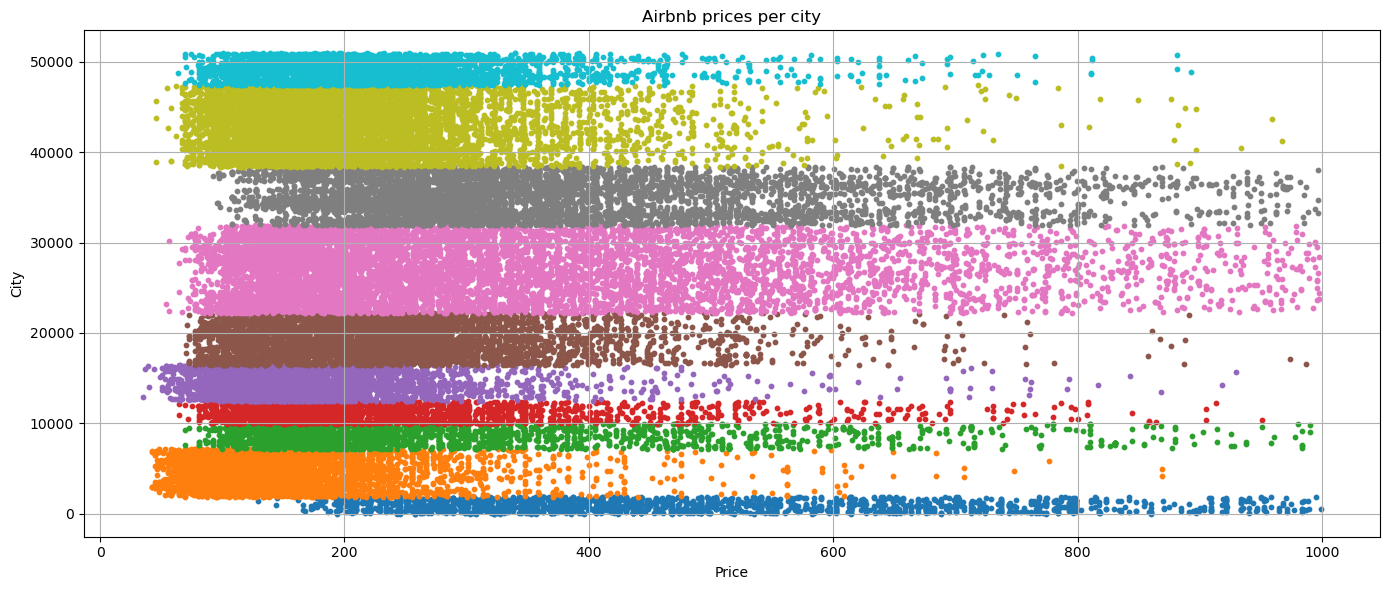

In [16]:
import matplotlib.pyplot as plt
df = pd.read_csv('../data/supervised_cleaned_airbnb_data.csv')

# Optional: filter out extreme values
df = df[df['realSum'] < 1000]

# Sort by city for consistent coloring
df = df.sort_values(by='City').reset_index(drop=True)

# Create scatter plot
plt.figure(figsize=(14, 6))

cities = df['City'].unique()
for city in cities:
    city_data = df[df['City'] == city]
    plt.scatter(city_data['realSum'], city_data.index, label=city, s=10)


# Formatting
plt.title('Airbnb prices per city')
plt.xlabel('Price')
plt.ylabel('City')
plt.grid(True)
plt.tight_layout()
plt.show()